In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 패키지
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import random


%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)


Tensorflow version: 2.12.0


In [ ]:
# 데이터 불러오기

df = pd.read_csv('/content/drive/MyDrive/인공지능/개인프로젝트/시계열 데이터/archive/realTweets/realTweets/Twitter_volume_GOOG.csv')
df.head(10)

,timestamp,value
0,2015-02-26 21:42:53,35
1,2015-02-26 21:47:53,41
2,2015-02-26 21:52:53,32
3,2015-02-26 21:57:53,36
4,2015-02-26 22:02:53,32
5,2015-02-26 22:07:53,25
6,2015-02-26 22:12:53,33
7,2015-02-26 22:17:53,20
8,2015-02-26 22:22:53,38
9,2015-02-26 22:27:53,28


In [ ]:
# 데이터 시각화
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.timestamp, y=df.value, mode='lines', name='value'))
fig.update_layout(showlegend=True)
fig.show()

In [ ]:
# Train & Test data size
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(12673, 2) (3169, 2)


# 데이터 전처리

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [ ]:
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# LSTM 모델




In [ ]:
time_steps=30
X_train, y_train = create_sequences(train[['value']], train.value, time_steps)
X_test, y_test = create_sequences(test[['value']], test.value, time_steps)
print(X_train.shape)

(12643, 30, 1)


In [ ]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [ ]:
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),

    TimeDistributed(Dense(num_features))
])
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

#훈련

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=16,
    validation_split=0.1,
    # callbacks=[es],
    shuffle=False
)

Epoch 1/300
712/712 [==============================] - 18s 10ms/step - loss: 0.3947 - val_loss: 0.2684
Epoch 2/300
712/712 [==============================] - 5s 7ms/step - loss: 0.3847 - val_loss: 0.2663
Epoch 3/300
712/712 [==============================] - 6s 9ms/step - loss: 0.3831 - val_loss: 0.2658
Epoch 4/300
712/712 [==============================] - 6s 8ms/step - loss: 0.3820 - val_loss: 0.2657
Epoch 5/300
712/712 [==============================] - 5s 8ms/step - loss: 0.3798 - val_loss: 0.2646
Epoch 6/300
712/712 [==============================] - 6s 8ms/step - loss: 0.3791 - val_loss: 0.2637
Epoch 7/300
712/712 [==============================] - 6s 8ms/step - loss: 0.3773 - val_loss: 0.2641
Epoch 8/300
712/712 [==============================] - 6s 9ms/step - loss: 0.3772 - val_loss: 0.2655
Epoch 9/300
712/712 [==============================] - 5s 7ms/step - loss: 0.3763 - val_loss: 0.2657
Epoch 10/300
712/712 [==============================] - 6s 8ms/step - loss: 0.3758 - val_

# 훈련 및 검증 그래프 시각화

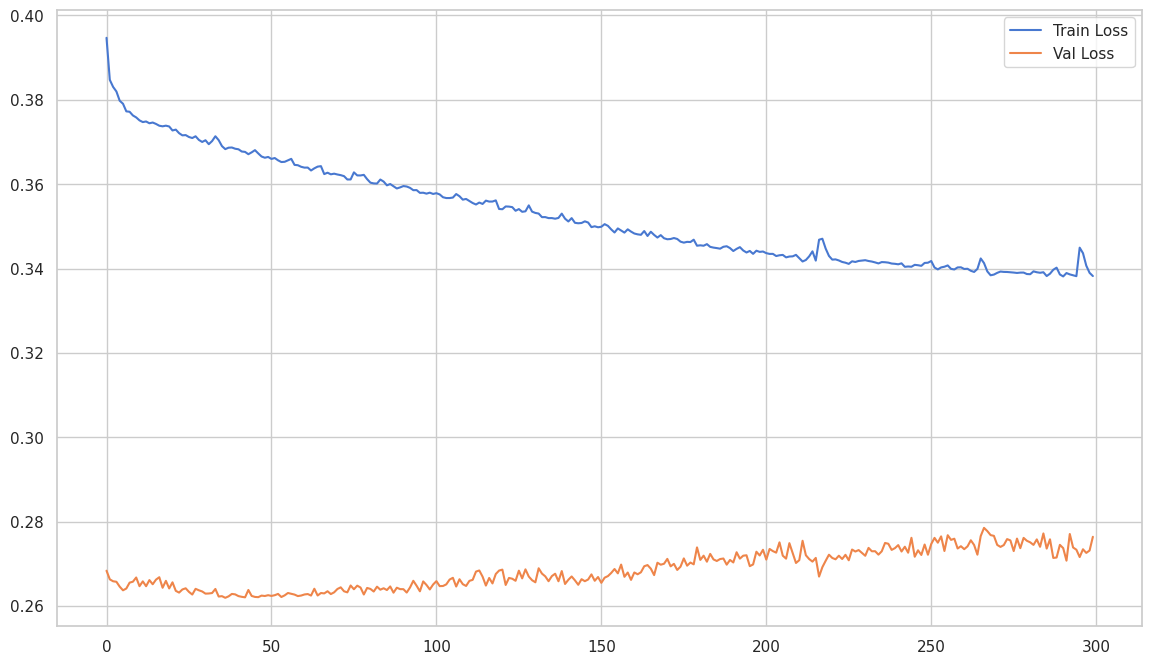

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

396/396 [==============================] - 3s 8ms/step


# 모델 테스트

In [ ]:
model.evaluate(X_test, y_test)

99/99 [==============================] - 1s 7ms/step - loss: 0.3381


0.3381247818470001

<Axes: ylabel='Count'>

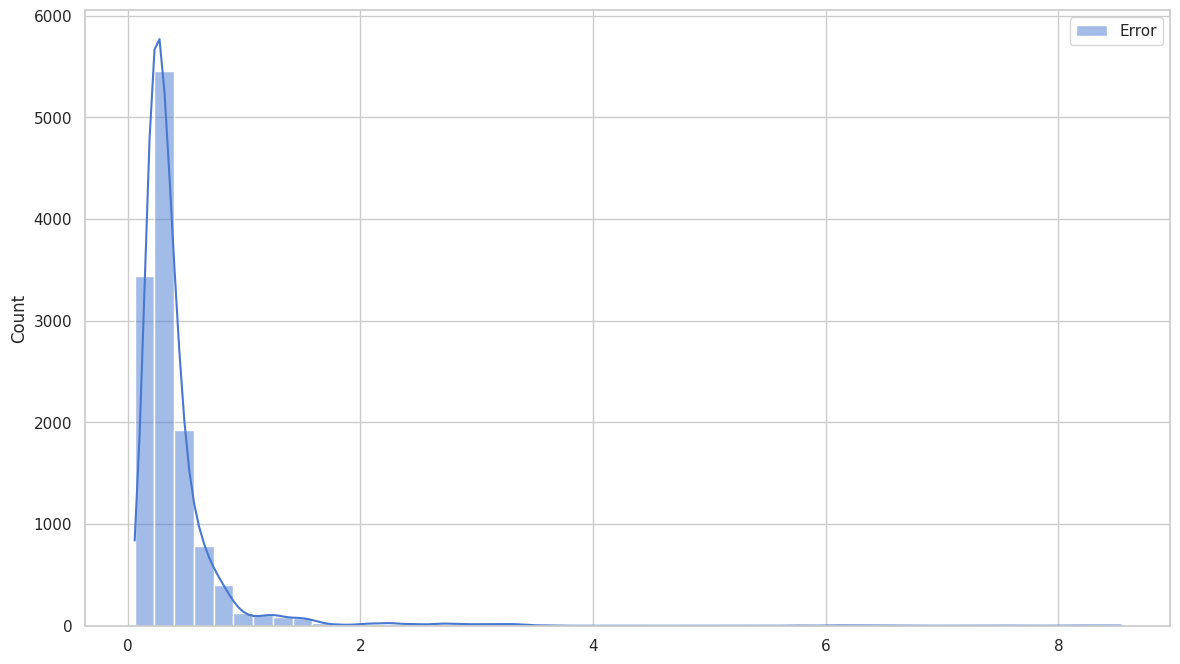

In [ ]:
sns.histplot(train_mae_loss, bins=50, kde=True)

In [ ]:
threshold = 0.65

In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

99/99 [==============================] - 0s 4ms/step


In [ ]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = test[time_steps:].value

In [ ]:
test_score_df.head(40)

,timestamp,value,loss,threshold,anomaly
12703,2015-04-12 00:17:53,-0.559018,0.192038,0.65,False
12704,2015-04-12 00:22:53,-0.663805,0.197811,0.65,False
12705,2015-04-12 00:27:53,-0.506624,0.200782,0.65,False
12706,2015-04-12 00:32:53,-0.454230,0.205827,0.65,False
12707,2015-04-12 00:37:53,-0.401836,0.182654,0.65,False
12708,2015-04-12 00:42:53,-0.663805,0.188092,0.65,False
12709,2015-04-12 00:47:53,-0.192261,0.186595,0.65,False
12710,2015-04-12 00:52:53,-0.349442,0.186329,0.65,False
12711,2015-04-12 00:57:53,-0.559018,0.191822,0.65,False
12712,2015-04-12 01:02:53,-0.716199,0.190738,0.65,False


In [ ]:
test_score_df.tail(50)


,timestamp,value,loss,threshold,anomaly
15792,2015-04-22 17:42:53,3.370518,0.917976,0.65,True
15793,2015-04-22 17:47:53,3.580094,0.898909,0.65,True
15794,2015-04-22 17:52:53,3.580094,0.972938,0.65,True
15795,2015-04-22 17:57:53,3.475306,0.956745,0.65,True
15796,2015-04-22 18:02:53,6.199784,0.916449,0.65,True
15797,2015-04-22 18:07:53,4.732758,1.042537,0.65,True
15798,2015-04-22 18:12:53,4.470788,1.147557,0.65,True
15799,2015-04-22 18:17:53,2.951368,0.998318,0.65,True
15800,2015-04-22 18:22:53,4.051638,0.908701,0.65,True
15801,2015-04-22 18:27:53,4.523182,0.967007,0.65,True


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].timestamp, y=test_score_df.loss,
                         mode='lines', name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].timestamp, y=test_score_df.threshold,
                         mode='lines', name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

4월 22일 방탄소년단이 트위터 2개를 올린 날이라 급격하게 올라간게 아닌가라는 생각을 해봄

한국시간 4월 23일이면 마국에서는 활발하게 활동하는 시간이라 그런게 아닌가라는 생각을 해봄